#Introduction

The prolblem of this report is that i need to build a model  to detect the prescence of a disease so it can help doctors identify a disease in my case breast cancer. the obecjtive of this report is to create a Cnn model that can tell if there is or isn't breast cancer and then improve it.

#Research and Data Exploration

##Paper Review

Paper Link https://cvpr.thecvf.com/virtual/2023/poster/21228


The paper that I have selected to review is a paper on how to improve pseudo labeling (meaning  prediction labels for unlabeled data which is then used as labeled samples during training) using Pseudo-loss Estimation and Feature Adversarial Training to improve and make it more accurate. I think the methods for this paper are good as they warm up the model with the entire dataset and use Contrastive Learning. The authors then acknowledge that they do this to stop confirmation bias in the model. They then use a GMM(Gaussian Mixture Model) on the labeled dataset to check the loss distributions. The authors then do a cross pseudo loss to compare the loss  distributions of the labeled and unlabeled data. The authors do feature adversarial training which gives more info on the unlabeled samples to use to discriminate against bad samples. The authors then show the results of using this compared to other methods. Were PEFAT scores higher than every one. My only issue with this is that one of the methods (ACPL) they tested it against is missing the specificity and accuracy on the 20% labeled test and every metric on the 5% labeled test. I feel like they maybe could have tested it to get those metrics. Overall I feel like the results are good and they even tested this with three datasets to make sure that this did improve scores across multiple datasets instead of only having benefits on one. For the limitations one that is mentioned is in the pseudo-labeling-based SSL paradigm where it relies on model initialization on the labeled dataset and the pseudo label data from the unlabeled dataset. I picked this paper because the title of it intrigued me and I wanted to learn if they could actually boost image classification scores. I then read the paper and learned that it can and that the authors tested it quite thoroughly by testing PEFAT on three different datasets. My only real gripe with the testing is that some evaluation metrics are missing from some methods so we just have to go on good faith that the methods with missing results perform worse than PEFAT and don’t perform better. I also liked that they showed formulas to explain the calculations for each step they were doing and that they explained everything in the methods.I also think the authors showing us pseudo code steps of how their PEFAT algorithm works is really good as it helped me understand the process better. Overall I think this is a good paper and the authors did a good job explaining how PEFAT improves image classification accuracy and was tested quite thoroughly.

## Data Exploration

Dataset link : https://www.kaggle.com/datasets/hayder17/breast-cancer-detection/data

My dataset is a breast cancer tumor dataset that has 3383 mammogram images. the images are put into 3 folders valid, test and train which are used for validation, testing and training respectively. inside these 3 folder there is two folders called 0 and 1. 0 stands for Benign(meaning these are images were there is no cancer) and 1 which stands for Malignant (Meaning these images have cancer / tumor). this data set was desinged for image classification more precisely binary classification (where we predict which two labels the image belongs to and give the label to the image). the datasets images are all the same size of 640*640. I chose this dataset because as it's a medical image dataset that's designed for image classification. there was also a good amount of images in the dataset

Adding Imports that i'll need for this coursework also added np.random seed to hopefully make the random weights as consistent as possible

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.image import imread
from PIL import Image
import tensorflow as tf
np.random.seed(1337)

it seems the other tensorflow imports are giving me issues so i'm going to install it to fix it

In [2]:
!pip install tensorflow

In [3]:
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, AveragePooling2D,Flatten, Dense, Conv2D,MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

i'm going to use kagglehub import download code to get my dataset as i won't have to deal with unzipping the file and google drive adding ds_store to folders as this mess up the model and makes is hard to split the folders. this also adds ds_store as a bit of data in the dataframes so that's another reason why i'm not doing it that way

In [4]:
import kagglehub

path = kagglehub.dataset_download("hayder17/breast-cancer-detection")

print("Path to dataset files:", path)

100%|██████████| 87.2M/87.2M [00:05<00:00, 16.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hayder17/breast-cancer-detection/versions/1


i want to see the folder paths so i can create file paths for them and i'll set my batch size, my image size and the number of epochs for the Cnn model. i decided to set the images to 128 as you can still see details and it doesn't take up too much memory.

In [5]:
print(os.listdir(path))
img_size = 128
batch_size = 16
n_epochs = 25

['valid', 'train', 'test']


set file paths for the validation data, the test data, and the training data so i can use throughout this coursework

In [6]:
valid = path + "/valid/"
test = path + '/test/'
train = path + '/train/'

I want to see the folders inside valid, train and ,test to see what the benign and malignant are called  

In [7]:
print(os.listdir(valid))
print(os.listdir(test))
print(os.listdir(train))

['0', '1']
['0', '1']
['0', '1']


in the dataset 0 = Benign and 1 = Malignant so I'll also make them labels to use for the get training data function  


In [8]:
labels = os.listdir(valid)

Create file paths for Benign and Malignant which i call 0 and 1 as i want to see how many images are in each folder and this is the most efficient way of doing it. these numbers will also tell me if if the dataset is imbalanced in anyway which i'll have to account for when i use the cnn model

In [9]:
test_0 = test+"0/"

test_1 = test+"1/"

train_0 = train+"0/"

train_1 = train+"1/"

valid_0 = valid+"0/"

valid_1 = valid+"1/"

number of images in test folder

In [10]:
print(f'The Number of benign images in Test {len(os.listdir(test_0))}')
print(f'The Number of Malignant images in Test {len(os.listdir(test_1))}')
print(f'The Number of images in Test {len(os.listdir(test_0))+len(os.listdir(test_1))}')

The Number of benign images in Test 208
The Number of Malignant images in Test 128
The Number of images in Test 336


number of images in train folder

In [11]:
print(f'The Number of benign images in Train {len(os.listdir(train_0))}')
print(f'The Number of Malignant images in Train {len(os.listdir(train_1))}')
print(f'The Number of images in Train {len(os.listdir(train_0))+len(os.listdir(train_1))}')

The Number of benign images in Train 1569
The Number of Malignant images in Train 803
The Number of images in Train 2372


number of images in valid set

In [12]:
print(f'The Number of benign images in Valid {len(os.listdir(valid_0))}')
print(f'The Number of Malignant images in Valid {len(os.listdir(valid_1))}')
print(f'The Number of images in Valid {len(os.listdir(valid_0))+len(os.listdir(valid_1))}')

The Number of benign images in Valid 448
The Number of Malignant images in Valid 227
The Number of images in Valid 675


The training, validation and test data are a bit imbalanced so i need to add a class weight to account for this imbalance so it doesn't have a bias and favour the data label that has more images and predict more in that label

function to load images and make the images all the same size and smaller and also make the data an np array so i can do np functions on the dataframes so i can see more information and visulaize the data in graphs

In [13]:
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data,dtype="object")

now i use my function on the dataset

In [14]:
train_ds = get_training_data(train)
test_ds = get_training_data(test)
valid_ds = get_training_data(valid)

now i use np.shape to see the size of the data and if it has the right amount of columns in this case 2

In [15]:
print(f'Shape of training set{train_ds.shape}')
print(f'Shape of test set{test_ds.shape}')
print(f'Shape of validation set{valid_ds.shape}')

Shape of training set(2372, 2)
Shape of test set(336, 2)
Shape of validation set(675, 2)


now i'm going create a graphs to better show/ visulaise how many benign and Malignant images there are in the training test and validation datasets as this is  good practise

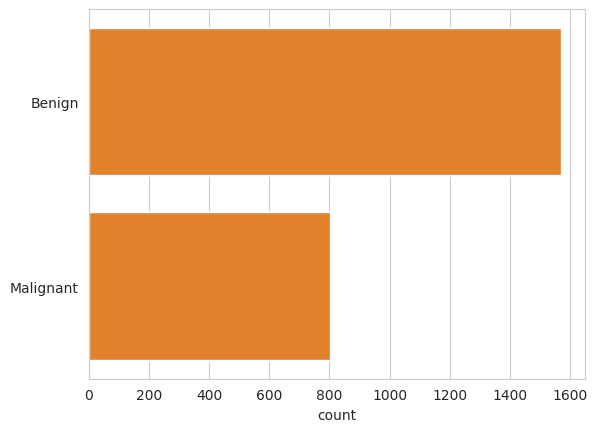

In [16]:
#create gird for training dataset
graphTrain = []

for i in train_ds:
  if(i[1]== 0):
    graphTrain.append("Benign")
  if(i[1]== 1):
    graphTrain.append("Malignant")
  sns.set_style('whitegrid')
  sns.countplot(graphTrain)

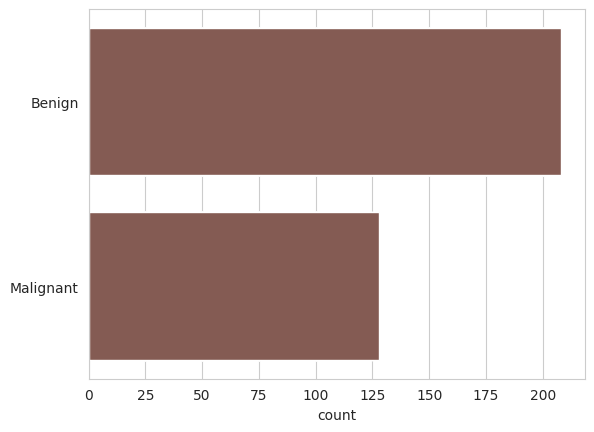

In [17]:
#create gird for test dataset
graphTrain = []

for i in test_ds:
  if(i[1]== 0):
    graphTrain.append("Benign")
  if(i[1]== 1):
    graphTrain.append("Malignant")
  sns.set_style('whitegrid')
  sns.countplot(graphTrain)

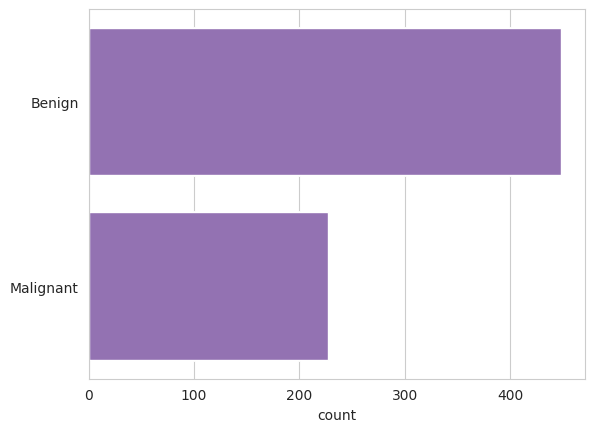

In [18]:
#create gird for valid dataset
graphTrain = []

for i in valid_ds:
  if(i[1]== 0):
    graphTrain.append("Benign")
  if(i[1]== 1):
    graphTrain.append("Malignant")
  sns.set_style('whitegrid')
  sns.countplot(graphTrain)

now i'm going to create a function to show what each type of image looks likes. this function can load as many images based on the number that is passed in so I can look at as many as i want

In [19]:
def show_images(number, benign=True):
    plt.figure(figsize=(12,12))
    if benign == True:
        for n in range(number):
            normal_img = os.listdir(train_0)[n]
            normal_img_address = train_0+normal_img
            normal_load = Image.open(normal_img_address)
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(normal_load, cmap ='gray')
            plt.title("Benign")
    else:
        for n in range(number):
            pneumonia_img =  os.listdir(train_1)[n]
            pneumonia_img_address = train_1+pneumonia_img
            pneumonia_load = Image.open(pneumonia_img_address)
            #cast nrows to integer
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(pneumonia_load, cmap ='gray')
            plt.title("Malignant")

    plt.axis("off")

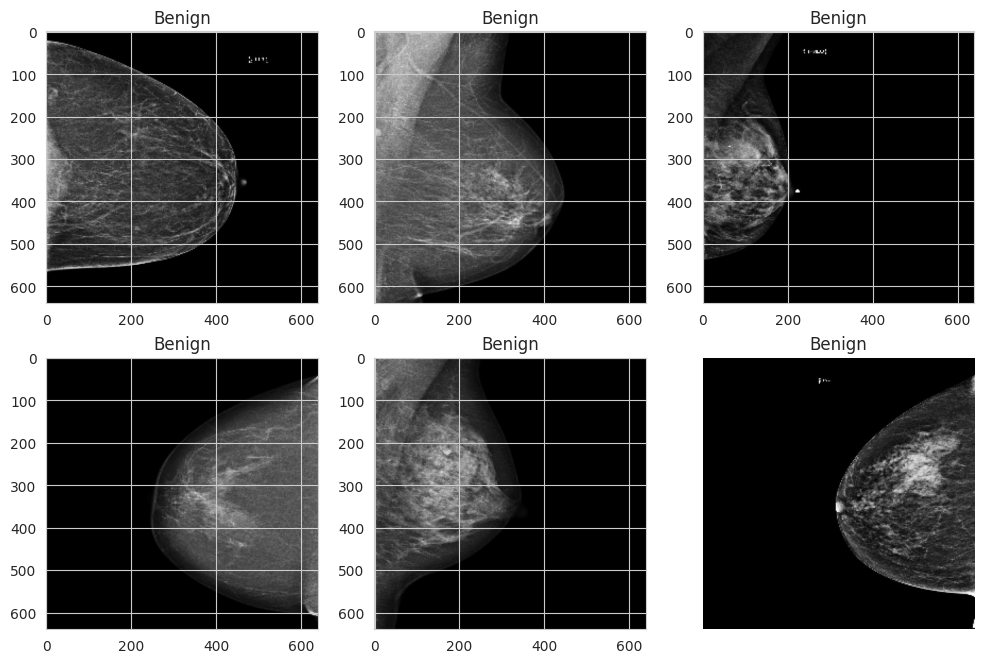

In [20]:
#show 6 bening images
show_images(6)

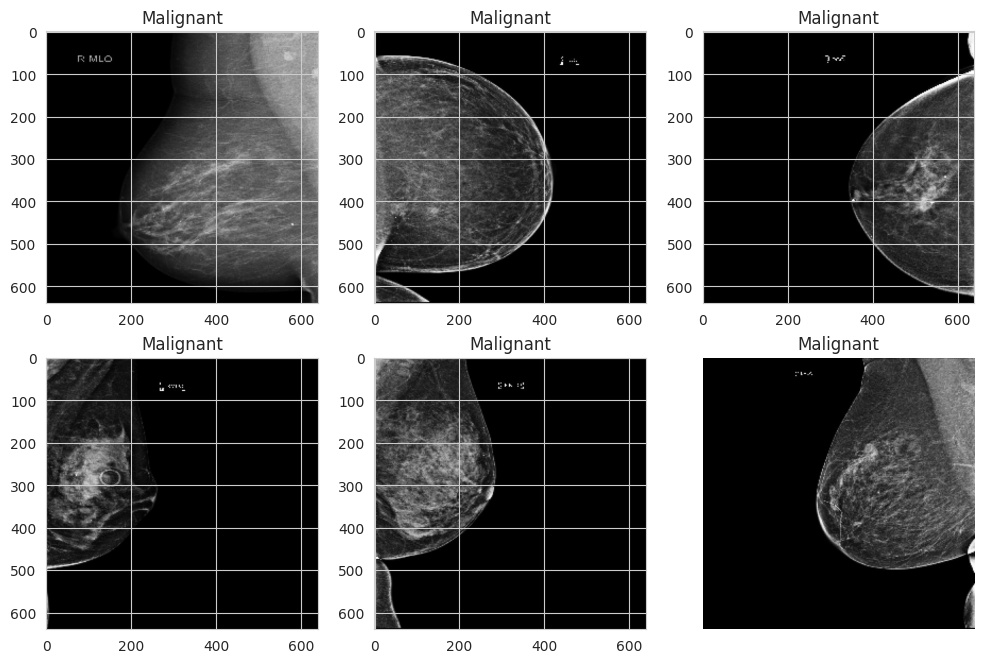

In [21]:
#show 6 Malignant images
show_images(6,False)

I'm going to apply histogram equalization to improve visualization as this can help show more diffrences

In [22]:
#!pip install scikit-image
from skimage import exposure

a function that does the histogram equalization to one image and is called in expose image

In [23]:
def equlize_hist_ (image):
  _image = np.asarray(image)
  image_eq = exposure.equalize_hist(_image)
  return image_eq

the function allows me to pick which type of image i want to see as this is useful to see the differenc between a benign image and a malignant image

In [24]:
def expose_image(benign=True):
    if benign==True:
        # Choose normal random image in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_0)))
        # image file name
        img_expose_name = os.listdir(train_0)[random_img_ind]

        # path to the image
        img_expose_address = train_0+img_expose_name

        # load image
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('benign')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('benign after HE')
        plt.axis("off")
    else:
        # Choose normal random image in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_1)))
        # image file name
        img_expose_name = os.listdir(train_1)[random_img_ind]

        # path to the image
        img_expose_address = train_1+img_expose_name

        # load mage
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('Malignant')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('Malignant after HE')
        plt.axis("off")


lets show a benign image and a Malignant image

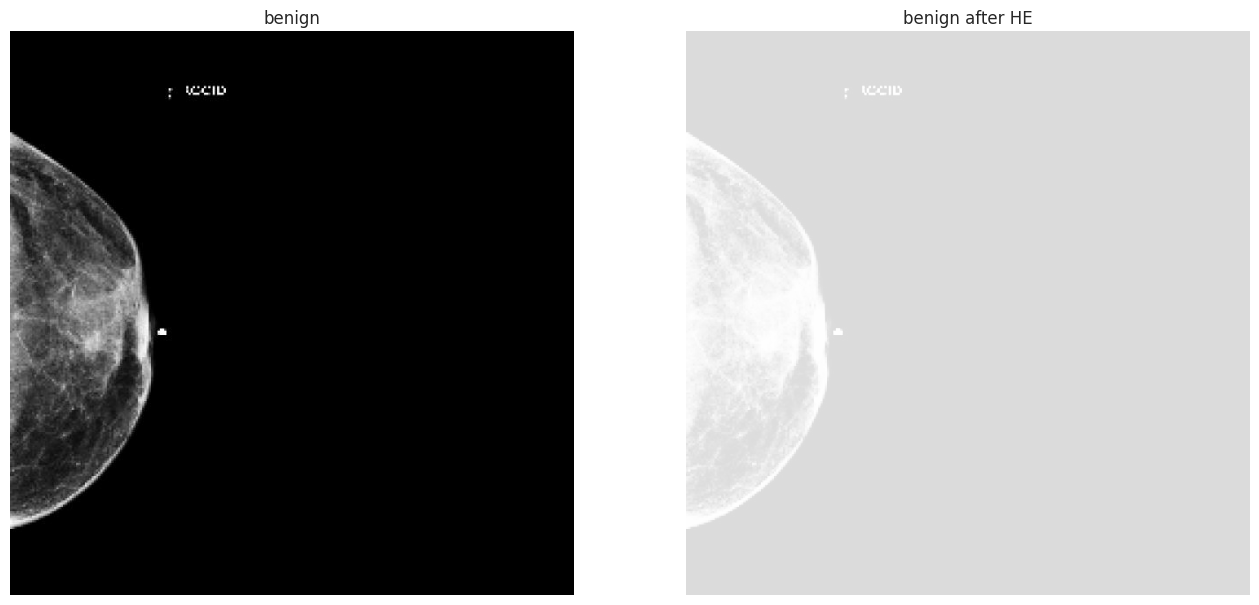

In [25]:
expose_image()

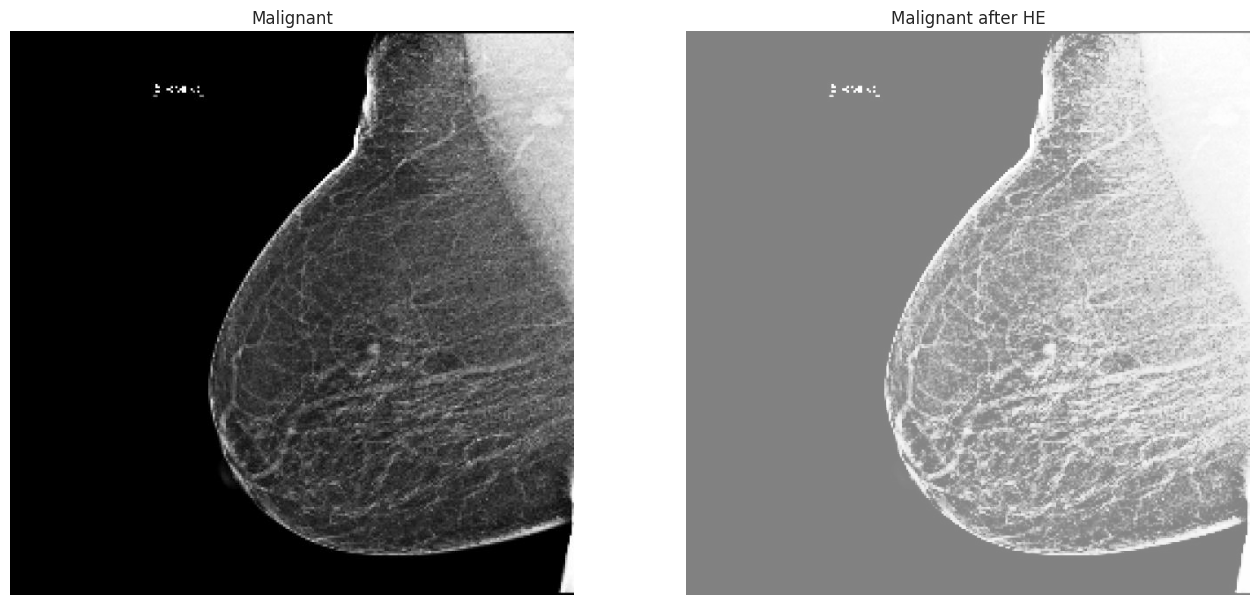

In [26]:
expose_image(False)

#Baseline Model

I now going to create a Cnn (Convolutional Neural Network) model to perform the image classification as this is what asked in the task for coursework and is the standard for image classification

In [27]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

#loop to append images to the x and y arrays
for feature, label in train_ds:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_ds:
    x_test.append(feature)
    y_test.append(label)

for feature, label in valid_ds:
    x_val.append(feature)
    y_val.append(label)

In [28]:
print(f'Number of images in the training set is {len(x_train)}')

Number of images in the training set is 2372


I'm going to normalise the data to make the variance 0 to 1 and make it more consistant to improve the models performance

In [29]:
# devide each of the x data by 255 to make it's pixel values between 0 and 1
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

I'm going to resize the array so i can perform deep learning as this improves performance of the Ccnn

In [30]:
# resize the array
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

i'm using keras ImageDataGenerator to do data augmentation( which is when you create new images for the dataset by changing them slightly i.e rotate,flip, zoom) as this should improve the performance of the model by giving it more images to work with meaning it has more images to compare to which should make it score higher in accuracy

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

datagen = ImageDataGenerator(

      featurewise_center=False,
      samplewise_center=False,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      zca_whitening=False,
      rotation_range = 30,
      zoom_range = 0.2,

      width_shift_range = 0.1,
      height_shift_range = 0.1,
      horizontal_flip = True,
      vertical_flip=False)

datagen.fit(x_train)

##CNN Model

for the Cnn model I set the optimizer to adam as it performed better when i tested it in labs and if you look on the github commits you can see that it performed better then rmsprop on this data set. i used batch normalization as this speeds up the Training of the model. I used dropout as this improves performance of the model and prevents overfitting in the model. i also increased the values for the drop offs as that improved the accuracy of the model.

In [32]:
# Model setup
model = Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(128, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(256, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(
              optimizer = 'adam', loss = 'binary_crossentropy',
              metrics = ['accuracy']
              )

In [33]:
# model summary (see the number of trainable parameters)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 952,065 (3.63 MB)

 Trainable params: 950,977 (3.63 MB)

 Non-trainable params: 1,088 (4.25 KB)

i need to create the weights for the model as the dataset is a bit unbalanced and i need the model to properly account for this other wise it will favour predicting Benign as that's the data there is more of that data

In [34]:
total = len(os.listdir(train_1)) + len(os.listdir(train_0))
neg = len(os.listdir(train_0))
pos = len(os.listdir(train_1))

weight_for_0 = 1/neg * (total/2.0)
weight_for_1 = 1/pos *(total/2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.7558954748247291, 1: 1.4769613947696139}

In [35]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

In [36]:
# Start training the model
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size),
                    epochs = n_epochs, validation_data = datagen.flow(x_val, y_val),
                    callbacks = [learning_rate_reduction], class_weight = class_weight)

Epoch 1/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 152ms/step - accuracy: 0.5046 - loss: 1.3843 - val_accuracy: 0.6637 - val_loss: 0.6942 - learning_rate: 0.0010
Epoch 2/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.5791 - loss: 0.7030 - val_accuracy: 0.6563 - val_loss: 0.6717 - learning_rate: 0.0010
Epoch 3/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5486 - loss: 0.6962
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.5485 - loss: 0.6961 - val_accuracy: 0.6519 - val_loss: 0.8253 - learning_rate: 0.0010
Epoch 4/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.5442 - loss: 0.6885 - val_accuracy: 0.6163 - val_loss: 0.7813 - learning_rate: 3.0000e-04
Epoch 5/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5616 - loss: 0.6901
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.5616 - 

i want to see the final results. I'm getting a higher val_loss which means that the model is overfitting

<Axes: >

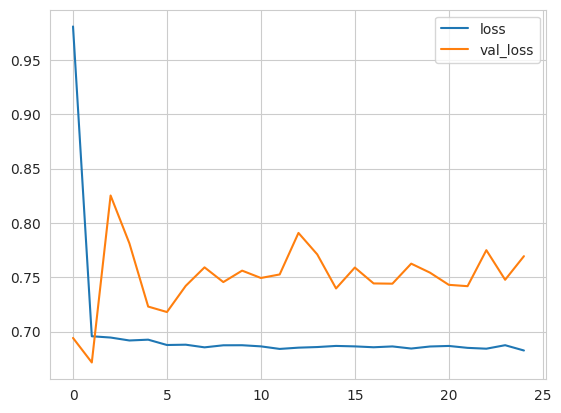

In [37]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

the val accuracy is higher than the accuracy

<Axes: >

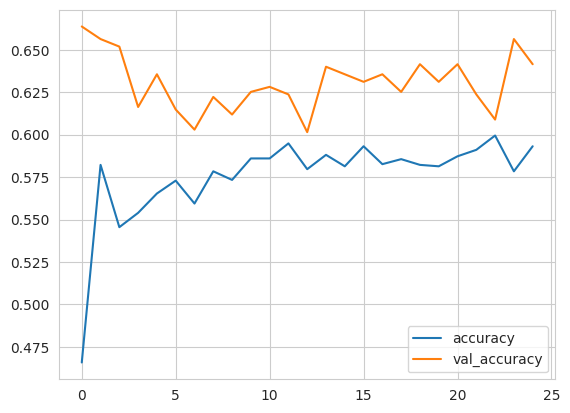

In [38]:
losses[['accuracy','val_accuracy']].plot()

i want to evaluate the accuracy and the loss  of the model to see how good the model is

In [39]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.5819 - loss: 0.6231
Loss of the model is -  0.7072946429252625
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5819 - loss: 0.6231
Accuracy of the model is -  55.35714030265808 %


now i want to see the predictions and use them to see the recall, precision and f1 score. recall is how many true positives there are.so out of every actual positive prediction how many did it get right. Precision is how many positives were actually positive. and f1 score is recall plus percision and is used to test how many it got right across the whole dataset. i'm getting these so i can use them for a confusion matrix

In [40]:
predictions=model.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


In [41]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, pred_labels, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.64      0.62      0.63       208
Malignant (Class 1)       0.42      0.44      0.43       128

           accuracy                           0.55       336
          macro avg       0.53      0.53      0.53       336
       weighted avg       0.56      0.55      0.56       336



now i'm going to visualize this as a confusion matrix so i can see how many true positives, false positives, true negatives and false negatives as these are good to know in medical areas. it is better to have as little false negatives as possible as someone needing medical care and being told you don't have a disease when they do is terrible and can result in death. false positives aren't great either but i think is it much better to be told you have a disease and do not have it as there isn't a risk of death

<Axes: >

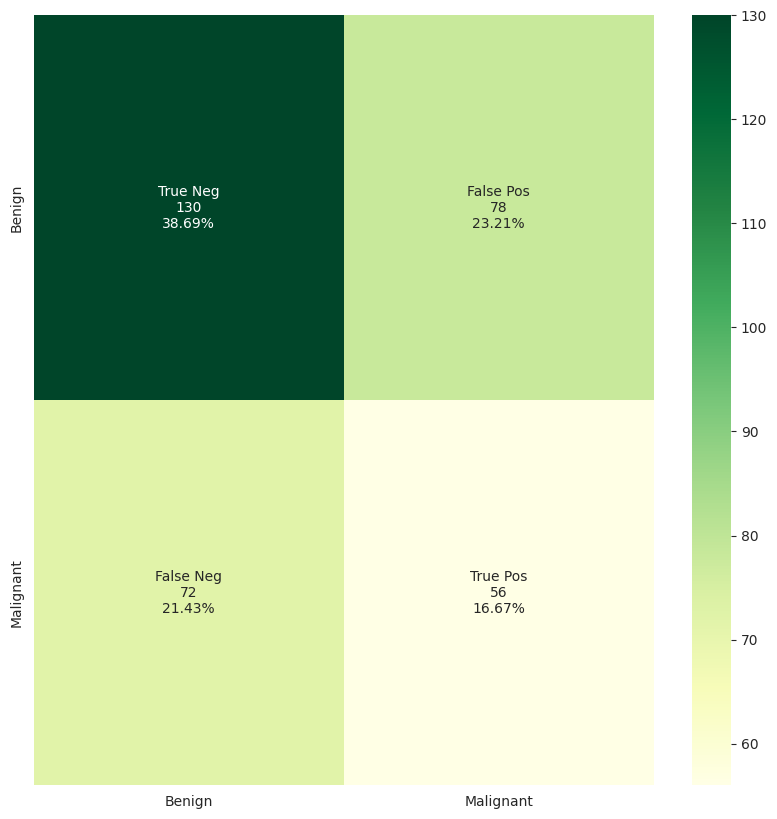

In [42]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))
classes = ['Benign','Malignant']
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
            xticklabels = classes,yticklabels = classes
           )

so my model has less false negatives then others that is really good as lower false negatives means there is less telling people that they don't have cancer when they do have cancer which is good for medical classification

then i'll store the predictions into a data frame then make an incorrect dataframe and use it to create a manual accuracy

In [43]:
# store result into a dataframe
results = pd.DataFrame({'Actual':y_test,'Predicted':pred_labels.flatten()})

#create incorrect dataframe
incorrect_df = results[results.Actual!=results.Predicted]
#show first five of incorrect
incorrect_df.head()

,Actual,Predicted
0,0,1
3,0,1
4,0,1
9,0,1
10,0,1


In [44]:
#manual calculation of accuracy rounded up
print(f'Accuracy is {round((results.shape[0]-incorrect_df.shape[0])/results.shape[0],2)*100} %')

Accuracy is 55.00000000000001 %


show the images of predictions so i can see what it predicted

In [45]:
correct = np.nonzero(pred_labels == y_test)[0]
incorrect = np.nonzero(pred_labels != y_test)[0]

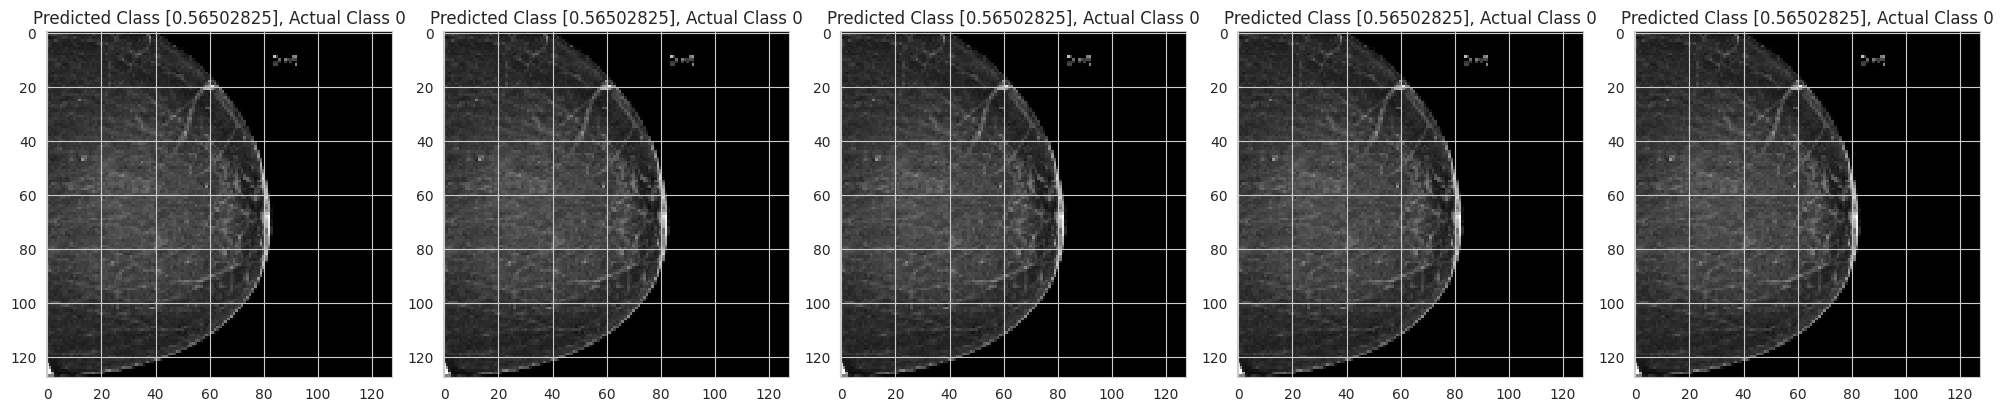

In [46]:
#correct predictions
i = 0
figure = plt.figure(figsize= (20,20))
for c in correct[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

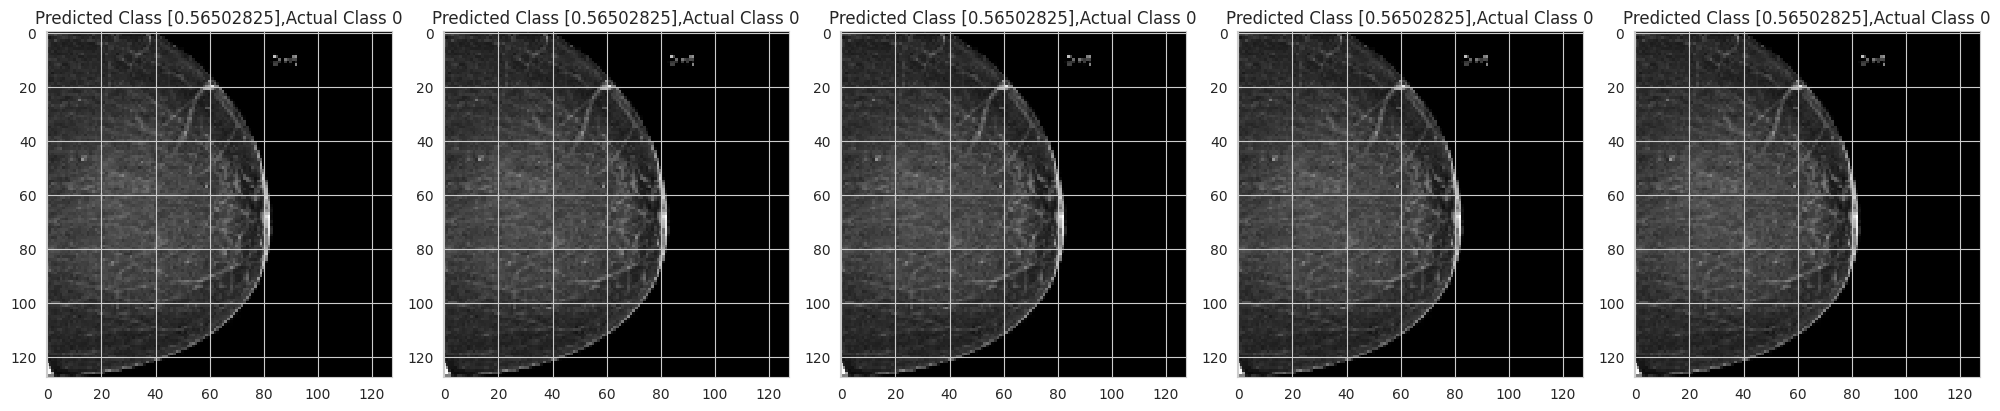

In [47]:
#incorrect predictions
i = 0
figure = plt.figure(figsize= (20,20))
for c in incorrect[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

#Solution Improvement

i'm going to use a pre trained model to try an improve the performance as it does in most case i'll start with using ResNet then fine tune it. after that i'll use InceptionV3 then fine tune it.as these have both been trained with more images so they should perfrom better

In [48]:
from keras.applications.inception_v3 import InceptionV3

In [49]:
# download the weights for ResNet model
tf.keras.backend.clear_session()

base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)
# freeze the layers
base_model.trainable = False

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [50]:
def get_pretrained():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_size,img_size, 3))

    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs], outputs=output)

    return model

In [51]:
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005), metrics=['binary_accuracy'])

model_pretrained.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 4, 4, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [52]:
history_tl = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    steps_per_epoch = int(x_train.shape[0]/batch_size),
                    class_weight = class_weight
                   )

Epoch 1/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 75s 293ms/step - binary_accuracy: 0.4836 - loss: 0.9108 - val_binary_accuracy: 0.4815 - val_loss: 0.7844 - learning_rate: 5.0000e-05
Epoch 2/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - binary_accuracy: 0.7500 - loss: 0.5134 - val_binary_accuracy: 0.5289 - val_loss: 0.7480 - learning_rate: 5.0000e-05
Epoch 3/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - binary_accuracy: 0.5377 - loss: 0.7405 - val_binary_accuracy: 0.5230 - val_loss: 0.7551 - learning_rate: 5.0000e-05
Epoch 4/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - binary_accuracy: 0.4375 - loss: 0.6967 - val_binary_accuracy: 0.5526 - val_loss: 0.7428 - learning_rate: 5.0000e-05
Epoch 5/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - binary_accuracy: 0.5545 - loss: 0.7335 - val_binary_accuracy: 0.5911 - val_loss: 0.6684 - learning_rate: 5.0000e-05
Epoch 6/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.5625 - loss: 0.5478 - val_binary_accuracy: 0.5674 - val_loss: 0.7

<Axes: >

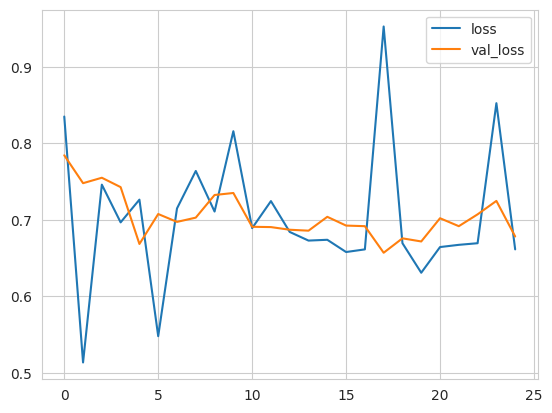

In [53]:
losses = pd.DataFrame(model_pretrained.history.history)
losses[['loss','val_loss']].plot()

<Axes: >

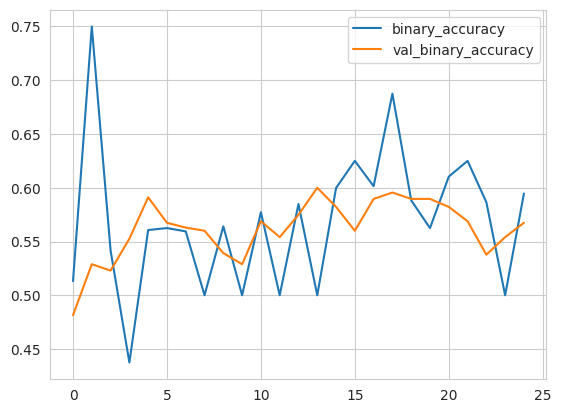

In [54]:
losses[['binary_accuracy','val_binary_accuracy']].plot()

In [55]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - binary_accuracy: 0.5510 - loss: 0.6711
Loss of the model is -  0.7038548588752747
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - binary_accuracy: 0.5510 - loss: 0.6711
Accuracy of the model is -  54.46428656578064 %


Fine Tunning Resnet

i'm going to fine tune this pre trained model as this can improve perfromance

In [56]:
#Fine tunning
base_model.trainable = True

# Retrain the last 10 layers (all lower layers will be kept frozen)
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [57]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=0.000002), metrics=['binary_accuracy'])

model_pretrained.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 4, 4, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 3,678,465 (14.03 MB)

 Non-trainable params: 54,915,584 (209.49 MB)

In [58]:
history_ft = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    steps_per_epoch = int(x_train.shape[0]/batch_size),
                    class_weight = class_weight
                   )

Epoch 1/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 80s 350ms/step - binary_accuracy: 0.6688 - loss: 0.6887 - val_binary_accuracy: 0.6178 - val_loss: 0.6584 - learning_rate: 2.0000e-06
Epoch 2/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - binary_accuracy: 0.6875 - loss: 0.8117 - val_binary_accuracy: 0.6207 - val_loss: 0.6620 - learning_rate: 2.0000e-06
Epoch 3/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - binary_accuracy: 0.6624 - loss: 0.6759 - val_binary_accuracy: 0.6104 - val_loss: 0.6683 - learning_rate: 2.0000e-06
Epoch 4/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - binary_accuracy: 0.6875 - loss: 0.7094 - val_binary_accuracy: 0.6178 - val_loss: 0.6685 - learning_rate: 2.0000e-06
Epoch 5/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - binary_accuracy: 0.6201 - loss: 0.6925 - val_binary_accuracy: 0.6104 - val_loss: 0.6656 - learning_rate: 2.0000e-06
Epoch 6/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.6875 - loss: 0.6432 - val_binary_accuracy: 0.6089 - val_loss: 0.

In [59]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 453ms/step - binary_accuracy: 0.6081 - loss: 0.6749
Loss of the model is -  0.682736873626709
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - binary_accuracy: 0.6081 - loss: 0.6749
Accuracy of the model is -  58.92857313156128 %


This imporved my performance even more so fine tuning works

In [60]:
predictions = model_pretrained.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


<Axes: >

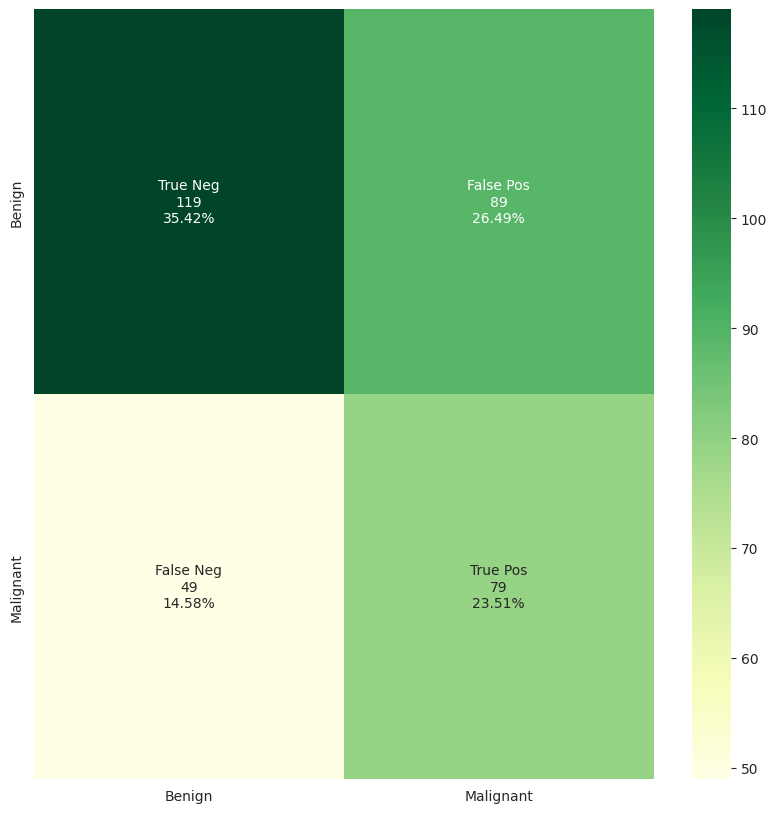

In [61]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
           xticklabels = classes,yticklabels = classes)

lets try InceptionV3 as a pretrained model which is just the same code with inceptionv3 instead

In [62]:
# download the weights for InceptionV3 model
tf.keras.backend.clear_session()

base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)
# freeze the layers
base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [63]:
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005), metrics=['binary_accuracy'])

model_pretrained.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [64]:
history_tl = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    steps_per_epoch = int(x_train.shape[0]/batch_size),
                    class_weight = class_weight
                   )

Epoch 1/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 49s 235ms/step - binary_accuracy: 0.5418 - loss: 0.7994 - val_binary_accuracy: 0.4800 - val_loss: 0.7778 - learning_rate: 5.0000e-05
Epoch 2/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - binary_accuracy: 0.3125 - loss: 1.1408 - val_binary_accuracy: 0.4637 - val_loss: 0.8102 - learning_rate: 5.0000e-05
Epoch 3/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - binary_accuracy: 0.5199 - loss: 0.7453 - val_binary_accuracy: 0.5704 - val_loss: 0.6994 - learning_rate: 5.0000e-05
Epoch 4/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - binary_accuracy: 0.7500 - loss: 0.5934 - val_binary_accuracy: 0.5644 - val_loss: 0.6879 - learning_rate: 5.0000e-05
Epoch 5/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - binary_accuracy: 0.5676 - loss: 0.7095 - val_binary_accuracy: 0.5570 - val_loss: 0.7037 - learning_rate: 5.0000e-05
Epoch 6/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - binary_accuracy: 0.6875 - loss: 0.6540 - val_binary_accuracy: 0.5467 - val_loss: 0.703

<Axes: >

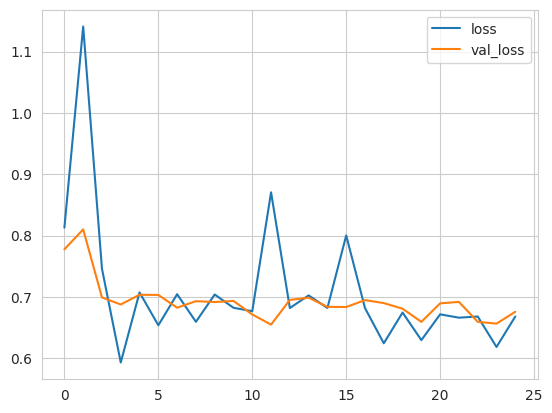

In [65]:
losses = pd.DataFrame(model_pretrained.history.history)
losses[['loss','val_loss']].plot()

<Axes: >

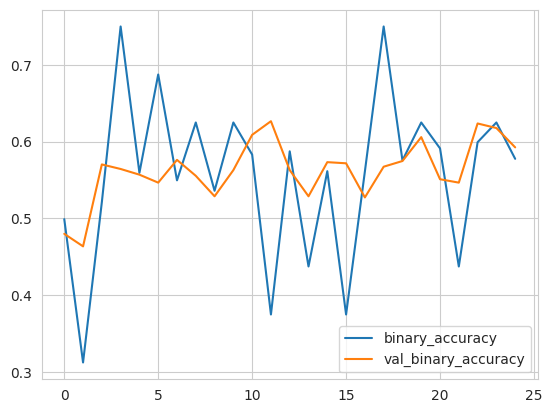

In [66]:
losses[['binary_accuracy','val_binary_accuracy']].plot()

In [67]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - binary_accuracy: 0.5903 - loss: 0.6750
Loss of the model is -  0.6887504458427429
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - binary_accuracy: 0.5903 - loss: 0.6750
Accuracy of the model is -  56.54761791229248 %


Fine Tunning inceptionv3

In [68]:
#Fine tunning
base_model.trainable = True

# Retrain the last 10 layers (all lower layers will be kept frozen)
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [69]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=0.000002), metrics=['binary_accuracy'])

model_pretrained.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,593 (1.00 MB)

 Non-trainable params: 21,802,592 (83.17 MB)

In [70]:
history_ft = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    steps_per_epoch = int(x_train.shape[0]/batch_size),
                    class_weight = class_weight
                   )

Epoch 1/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 44s 207ms/step - binary_accuracy: 0.5927 - loss: 0.6702 - val_binary_accuracy: 0.5674 - val_loss: 0.6653 - learning_rate: 2.0000e-06
Epoch 2/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.4375 - loss: 0.8521 - val_binary_accuracy: 0.5630 - val_loss: 0.6737 - learning_rate: 2.0000e-06
Epoch 3/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - binary_accuracy: 0.5903 - loss: 0.6690 - val_binary_accuracy: 0.5585 - val_loss: 0.6780 - learning_rate: 2.0000e-06
Epoch 4/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - binary_accuracy: 0.6875 - loss: 0.5630 - val_binary_accuracy: 0.5748 - val_loss: 0.6737 - learning_rate: 2.0000e-06
Epoch 5/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - binary_accuracy: 0.5859 - loss: 0.6612 - val_binary_accuracy: 0.5630 - val_loss: 0.6840 - learning_rate: 2.0000e-06
Epoch 6/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - binary_accuracy: 0.5000 - loss: 0.6402 - val_binary_accuracy: 0.5896 - val_loss: 0.675

In [71]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - binary_accuracy: 0.5814 - loss: 0.6927
Loss of the model is -  0.6899519562721252
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.5814 - loss: 0.6927
Accuracy of the model is -  56.84523582458496 %


In [72]:
predictions = model_pretrained.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 631ms/step


<Axes: >

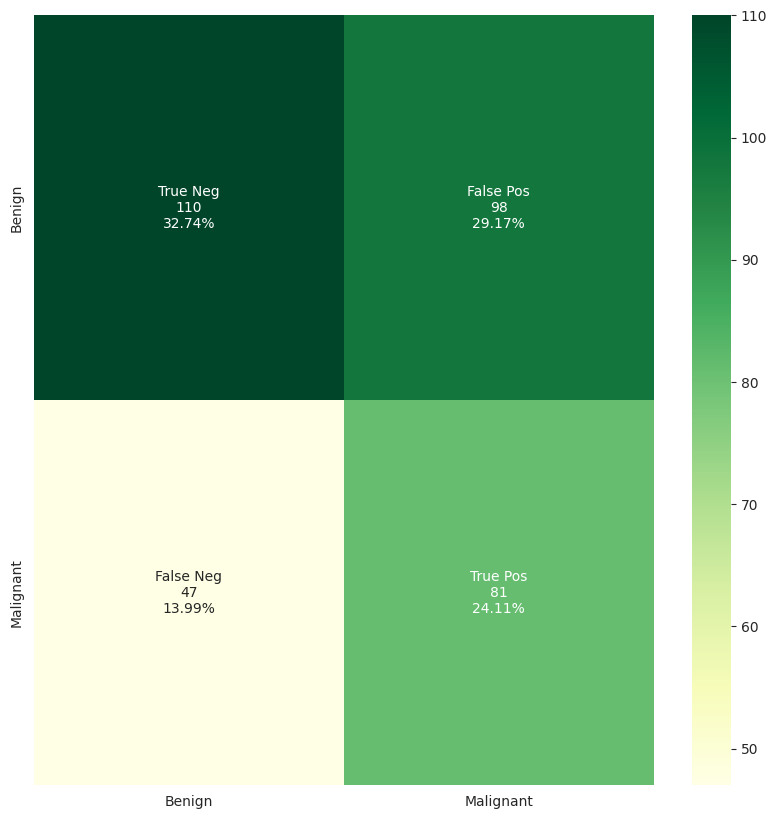

In [73]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
           xticklabels = classes,yticklabels = classes)

it seems from this InceptionV3 did worse overall compared to resNet but they were both improvments over the base models when fine tuned except resnet this run other runs i have done have had it perform better than the base model so this a bit odd

#Conclusion and Future Direction

In conclusion i created a cnn model for image classification on a breast cancer dataset. I think the performance without any of the solution fixes is not that great and seems to be a bit inconsistant, if you look at one of the prevous version of this on github i got about 57% on the accuracy then in another run i got 45% percent. i think the thing causing this is the weights being generated randomly . as any time I disconnect the runtime and re run the model i'll always get a different score of accuracy. some things that were consisant was that the solution improvements all improved the performance most of the time. the pre trained models and the fine tunning appiled to them improved the perfomrance by a few percentage most of time so that's good. A thing i could do to improve the performance is increase the image size if google colab alowed me to use more ram as that would most likely give higher accuracy. For the expreiments i disconnected and clearned the runtime to clear the memory and just ran it and this is how i found out it's a little inconsistant. I didn't really change much the only thing i changed was the optimzer to adam which improved my perfomrance and the dropout values as that also improved my perfromance from testing. overall i feel the model is decent but to be more relaible with this dataset it needs the solution improvements.